In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import csv
import tqdm

# Prepering the data

In [2]:
files = glob('data_set/*.csv')

In [3]:
my_file = []
def delete_lines_and_save(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Delete the first five lines
    modified_lines = lines[5:]

    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([line.strip().split(',') for line in modified_lines])

    #print(f"Modified CSV file saved as '{output_file}'.")


for file in files:
    delete_lines_and_save(file, 'drop 5 lines data_set/' + file.split('\\')[1])
    my_file.append('drop 5 lines data_set/' + file.split('\\')[1])

In [4]:
def convert_to_floats(dataframe):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column].astype(str).str.replace('"', ''), errors='coerce')
    return dataframe

import re

data = []
for file in my_file:
    #print(file)
    d = pd.read_csv(file)

    file_name = "data_set/" + file.split('/')[1]
    with open(file_name, 'r') as file1:
        lines = file1.readlines()
    sanity_check = "COUNTS OF ACTUAL STEPS:" in lines[3].split(',')[0] or "COUNT OF ACTUAL STEPS:" in lines[3].split(',')[0]
    if not sanity_check:
        steps = lines[3].split(',')[0]
    else:
        steps = lines[3].split(',')[1]

    # get first int from string with regex
    steps = int(re.findall(r'\d+', steps)[0])

    #delete every column geater than 3
    #d = d.loc[:, d.columns != 'Unnamed: 4']

    # take the first 4 columns
    d = d.iloc[:, :4]

    # values to float from string with apply
    
    d = convert_to_floats(d)
    
    
    # rename columns
    d.columns = ['time', 'acc_x', 'acc_y', 'acc_z']
    walking = "walk" in file
    data.append([d, walking, steps])

In [5]:
my_file[0]

'drop 5 lines data_set/10_run_1_2.csv'

In [6]:
data[0]

[          time  acc_x  acc_y  acc_z
 0     0.000000   5.61  -0.75  -3.84
 1     0.067109   9.57  -0.43  -5.49
 2     0.134218  12.04   0.16  -6.59
 3     0.260047  10.94   0.35 -13.26
 4     0.318767   7.02   3.92 -14.32
 ..         ...    ...    ...    ...
 639  60.389589  11.18   1.22 -16.87
 640  60.456698  16.12   3.33  -8.51
 641  60.590916  11.77   1.41  -4.90
 642  60.641247  -8.59  -1.33  -3.30
 643  60.708356   0.59  -0.75  -3.30
 
 [644 rows x 4 columns],
 False,
 163]

In [7]:
data

[[          time  acc_x  acc_y  acc_z
  0     0.000000   5.61  -0.75  -3.84
  1     0.067109   9.57  -0.43  -5.49
  2     0.134218  12.04   0.16  -6.59
  3     0.260047  10.94   0.35 -13.26
  4     0.318767   7.02   3.92 -14.32
  ..         ...    ...    ...    ...
  639  60.389589  11.18   1.22 -16.87
  640  60.456698  16.12   3.33  -8.51
  641  60.590916  11.77   1.41  -4.90
  642  60.641247  -8.59  -1.33  -3.30
  643  60.708356   0.59  -0.75  -3.30
  
  [644 rows x 4 columns],
  False,
  163],
 [          time  acc_x  acc_y  acc_z
  0     0.000000   8.43   2.94  -4.55
  1     0.016777   9.18   3.02  -4.67
  2     0.033554  10.32   1.61  -5.81
  3     0.041943   9.14   0.59    NaN
  4     0.109052   5.41   1.77 -11.18
  ..         ...    ...    ...    ...
  647  60.607693  -7.77   1.84  -2.90
  648  60.691579   1.73   1.77  -2.90
  649  60.775465  20.01   4.63 -20.01
  650  60.867740  12.32   0.00  -7.45
  651  60.943237  -0.63   0.59  -3.18
  
  [652 rows x 4 columns],
  False,
  16

# Walking or Running

In [124]:
def classify(data):
    # max l2 norm of acceleration
    norms = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
    
    # max acceleration
    max_acc = np.max(norms)

    max_acc = min(max_acc, 50)

    return max_acc > 20, max_acc

In [125]:
classify(data[0][0])

(True, 30.988983526408223)

In [10]:
import tqdm
# lets calculate the accuarcy of the classifier
true_labels = []
predicted_labels = []
my_dict = {"walking":[], "running":[]}
for d in tqdm.tqdm(data):
    frame_labels = []
    for i in range(20, len(d[0])):

        # take the last 10 values
        last_10 = d[0].iloc[i-20:i]
        # classify
        classified, max_acc = classify(last_10)
        # append predicted label
        frame_labels.append(classified)

        # append to dict
        if d[1]:
            my_dict["walking"].append(max_acc)
        else:
            my_dict["running"].append(max_acc)
    
    pred = np.mean(frame_labels) < 0.5

    true_labels.append(d[1])
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

  0%|          | 0/280 [00:00<?, ?it/s]

100%|██████████| 280/280 [04:11<00:00,  1.11it/s]


In [11]:
# calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
accuracy

0.9

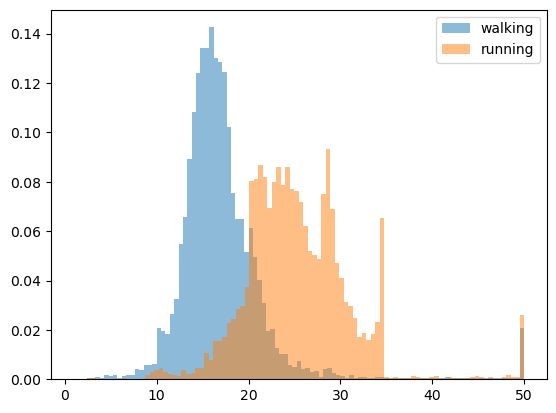

In [123]:
# plot the distribution of the max acceleration
import matplotlib.pyplot as plt

# normalize to distribution
plt.hist(my_dict["walking"], bins=100, alpha=0.5, label='walking', density=True)
plt.hist(my_dict["running"], bins=100, alpha=0.5, label='running', density=True)
plt.legend(loc='upper right')
plt.show()

# How many steps

In [8]:
def smooth_signal_fast(lst, window_size=10):
    cumsum_vec = np.cumsum(np.insert(lst, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

In [9]:
def exp_smooth_signal(lst, alpha=0.1):
    s = np.zeros(len(lst))
    s[0] = lst[0]
    for i in range(1, len(lst)):
        s[i] = alpha * lst[i] + (1 - alpha) * s[i-1]
    return s
    

In [10]:
# classic method for counting steps
from scipy.signal import find_peaks

def count_steps(data, threshold=1.8, distance=3, low_pass=350):
    # plot data
    # plt.plot(data)
    # plt.show()

    # Apply Fast Fourier Transform (FFT)
    fft_values = np.fft.rfft(data)
    
    # Low pass filter
    fft_values[low_pass:] = 0

    # Apply Inverse Fast Fourier Transform (IFFT) to get the filtered signal
    data = np.fft.irfft(fft_values)

    # plot filtered data
    # plt.plot(data)
    # plt.show()


    peaks, _ = find_peaks(data, threshold=threshold, distance=distance)
    return str(len(peaks))

In [11]:

best_treshold = {"walking": 1.5, "running": 1.5}
best_distance = {"walking": 0.35, "running": 0.35}
best_loss = {"walking": 1, "running": 1}
best_low_pass = {"walking": 350, "running": 350}

best_window_size = {"walking": 10, "running": 10}

blacklist = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]

win_size = 0.35

for treshold in tqdm.tqdm(np.arange(0, 0.02, 0.001)):
    for low_pass in [260, 270, 280, 290, 300, 310]:
        for distance in np.arange(2, 5, 1):

                real = {"walking": [], "running": []}
                pred = {"walking": [], "running": []}
                for idx, d in enumerate(data):
                    if idx in blacklist:
                        continue

                    if d[1]:
                        category = "walking"
                    else:
                        category = "running"

                    # calc l2 norm of acceleration
                    norms = np.sqrt(d[0]['acc_x']**2 + d[0]['acc_y']**2 + d[0]['acc_z']**2)
        
                    # remove nan values
                    norms = norms[~np.isnan(norms)]
                    
                    # norms to float array
                    lst = np.array(norms)

                    m = np.mean(lst)

                    if m > 35:
                        continue

                    # if norm > 35  then norm = m
                    lst[lst > 35] = m

                    # normalize
                    lst = (lst - m) / np.std(lst)

                    #lst = smooth_signal_fast(lst, window_size=win_size)
                    lst = exp_smooth_signal(lst, alpha=win_size)

                    cs = count_steps(lst, threshold=treshold, distance=distance, low_pass=low_pass)

                    real[category].append(d[2])
                    pred[category].append(int(cs))

                # calc loss
                for c in ["walking", "running"]:
                    r = np.array(real[c])
                    p = np.array(pred[c])
                    loss = np.abs(1 - p / r)

                    if np.mean(loss) < best_loss[c]:
                        best_loss[c] = np.mean(loss)
                        best_treshold[c] = treshold
                        best_distance[c] = distance
                        best_window_size[c] = win_size
                        best_low_pass[c] = low_pass

100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


In [12]:
best_treshold

{'walking': 0.019, 'running': 0.01}

In [13]:
best_distance

{'walking': 4, 'running': 3}

In [14]:
# best_loss = {'walking': 0.1927102571668052, 'running': 0.1507345513997464}
# best_treshold = {'walking': 0.042, 'running': 0.01}
# best_distance = {'walking': 4, 'running': 3}
# best_window_size = {'walking': 0.44999999999999996, 'running': 0.3}

# plot stuff

In [18]:
real = {"walking": [], "running": []}
pred = {"walking": [], "running": []}

blacklist = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]

best_median = {"walking": 0, "running": 0}

for idx, d in enumerate(data):
    if idx in blacklist:
        continue

    if d[1]:
        category = "walking"
    else:
        category = "running"

    # calc l2 norm of acceleration
    norms = np.sqrt(d[0]['acc_x']**2 + d[0]['acc_y']**2 + d[0]['acc_z']**2)
    
    # remove nan values
    norms = norms[~np.isnan(norms)]

    m = np.mean(norms)

    if m > 35:
        continue

    # if norm > 35  then norm = m
    norms[norms > 35] = m

    # normalize
    norms = (norms - m) / np.std(norms)

    # smooth
    norms = np.array(norms)
    #norms = smooth_signal_fast(norms, window_size=best_window_size[category])
    norms = exp_smooth_signal(norms, alpha=best_window_size[category])

    # norms = norms - np.min(norms)
    # norms = norms / np.max(norms) 

    # clac median of norms
    # median = np.median(norms)
    # print(median)
    
    # plt.plot(norms)
    # plt.title(category + " " + str(d[2]) + " idx: " + str(idx))
    # plt.show()

    # norms to float array
    lst = np.array(norms)

    threshold=best_treshold[category]
    distance=best_distance[category]
    #threshold = 1.8
    #distance=3

    cs = count_steps(lst, threshold=threshold, distance=distance, low_pass=best_low_pass[category])

    real[category].append(d[2])
    pred[category].append(int(cs))

# calc loss
for c in ["walking", "running"]:
    r = np.array(real[c])
    p = np.array(pred[c])
    loss = np.abs(1 - p / r)
    best_median[c] = np.median(loss)
    print(c, np.median(loss))

walking 0.128
running 0.07096774193548383


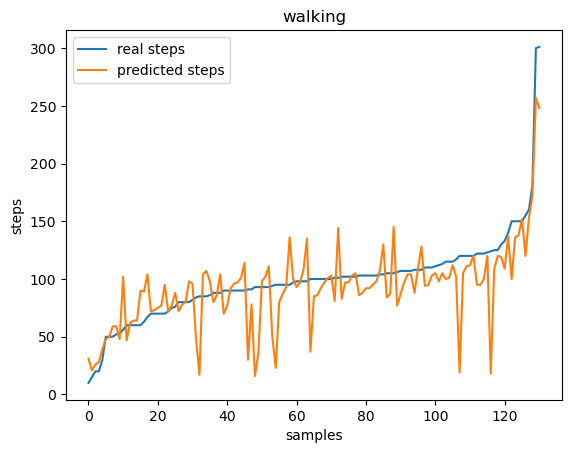

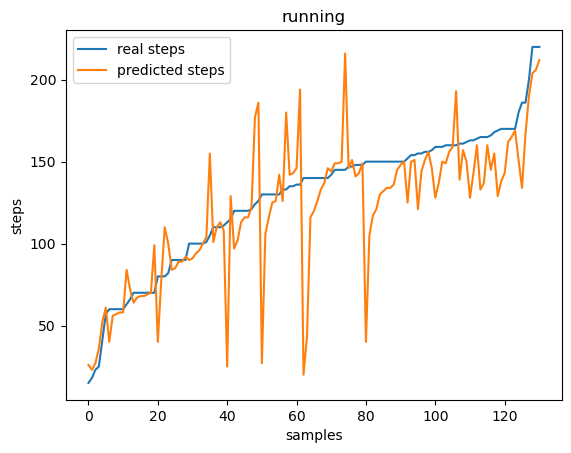

In [19]:
# plot beutiful graphs

# zip them
# sort them
# unzip them
# plot them

import matplotlib.pyplot as plt

for category in ["walking", "running"]:
    r = np.array(real[category])
    p = np.array(pred[category])
    r, p = zip(*sorted(zip(r, p)))
    plt.plot(r, label = "real steps")
    plt.plot(p, label = "predicted steps")
    plt.xlabel("samples")
    plt.ylabel("steps")
    plt.legend(loc='upper left')
    plt.title(category)
    plt.show()

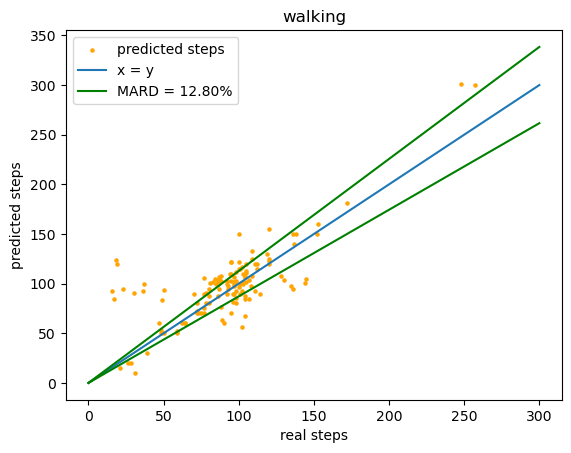

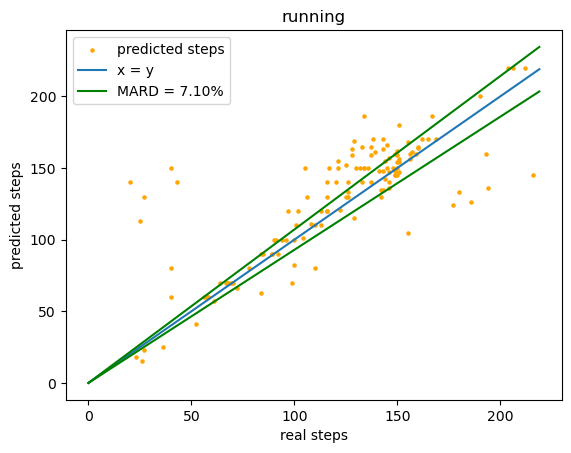

In [20]:
for category in ["walking", "running"]:
    r = np.array(real[category])
    p = np.array(pred[category])
    r, p = zip(*sorted(zip(r, p)))
    plt.scatter(p, r, label = "predicted steps", s=5, color = "orange")
    # straigh line
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)), label = "x = y")
    # ten precent relative error
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)) * (1 + best_median[category]), label = f"MARD = {best_median[category] * 100:.2f}%", color = "green")
    # ten precent relative error
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)) * (1 - best_median[category]), color = "green")
    plt.xlabel("real steps")
    plt.ylabel("predicted steps")
    plt.legend(loc='upper left')
    plt.title(category)
    plt.show()